In [1]:
# Set directory to main directory (only run this once)
import os
dir_path = os.getcwd()
os.chdir('/'.join(dir_path.split('/')[:-1]))

In [2]:
# Import things
import numpy as np
import torch
import torch
import torch.func as func
import matplotlib.pyplot as plt
from PIL import Image
from src.domain import Domain
from src.utils import *
from src.transformations import Affine2d
from src.interpolation import SplineInter 
from src.plotting import view_image_2d
from src.interpolation import SplineInter
from src.distance import SSDDistance
from src.LinearOperator import LinearOperator

torch.set_default_dtype(torch.float64)

# Estimating Dynamics from an Unregistered Time Series

In [3]:
# Load data
root_directory = 'data/dynamics/d_affine/'

domain = Domain.load(root_directory + 'domain')
time = torch.load(root_directory + 'time.pt').double().detach()
d_2d = torch.load(root_directory + 'd.pt').double().detach()
f_2d = torch.load(root_directory + 'f_true.pt').double().detach()
masks_2d = torch.load(root_directory + 'masks.pt').double().detach()
alpha_true = torch.load(root_directory + 'alpha_true.pt').double().detach()


mx,my = domain.m
n_images = len(time)
n_masks = masks_2d.shape[0]

hx,hy = domain.h
ht = time[1] - time[0]

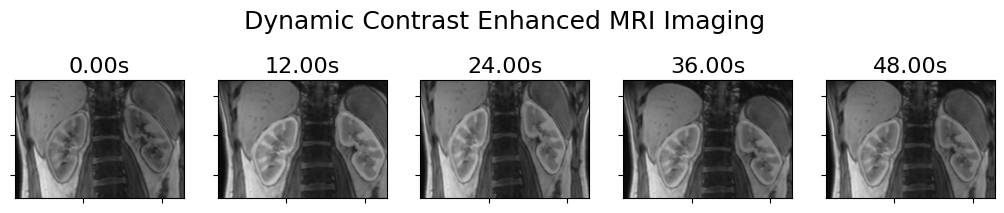

In [4]:
fig, ax = plt.subplots(1,5, figsize=(10,2.6))

for j in range(5):
    im = view_image_2d(d_2d[5*j], domain, ax=ax[j], kwargs={'clim':(0,300), 'cmap':'Greys_r'})
    ax[j].set_title("{:.2f}s".format(time[5*j].item()),fontsize=16)
    ax[j].set_xticklabels([])
    ax[j].set_yticklabels([])

fig.suptitle('Dynamic Contrast Enhanced MRI Imaging', y = .95, fontsize=18)

fig.subplots_adjust(0.01,-.1,.99,1)

plt.savefig('results/dynamics/contrast_demonstration.pdf')
plt.show()

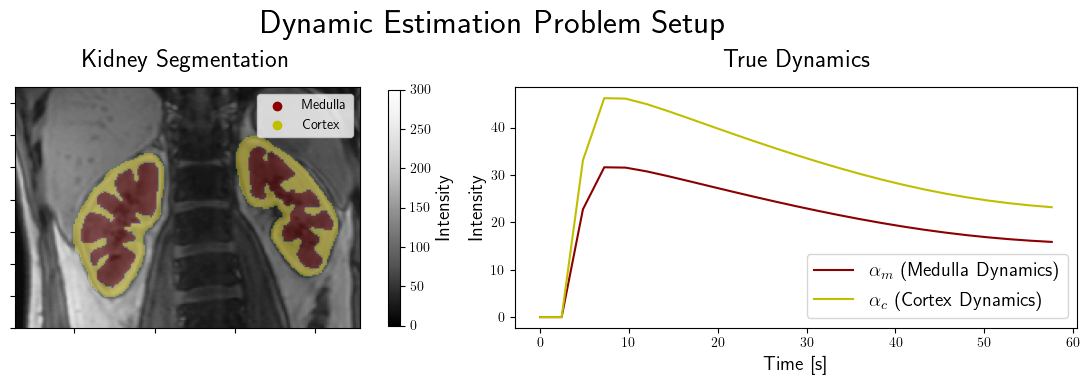

In [5]:
plt.rcParams['text.usetex'] = True

fig, ax = plt.subplots(1,2,figsize = (12,4), width_ratios=[1,1], layout='tight')

im = view_image_2d(d_2d[0],domain, ax = ax[0], kwargs={'clim':(0,300), 'cmap':'Greys_r'})
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])

view_image_2d(masks_2d[0],domain,{'alpha':.4*masks_2d[0].T,'cmap':'seismic'}, ax=ax[0])
view_image_2d(masks_2d[1],domain,{'alpha':.4*masks_2d[1].T}, ax=ax[0])

ax[0].scatter([],[],color='darkred',label="Medulla")
ax[0].scatter([],[],color='y',label="Cortex")
ax[0].legend()

ax[0].set_title("Kidney Segmentation", y=1.05, fontsize = 18)

cbar = plt.colorbar(im,shrink=.98)
cbar.set_label(label = "Intensity", fontsize = 14)

ax[1].plot(time, alpha_true[:,0], color='darkred', label=r"$\alpha_m$ (Medulla Dynamics)")
ax[1].plot(time, alpha_true[:,1], color='y', label=r"$\alpha_c$ (Cortex Dynamics)")
ax[1].legend(fontsize=14)

ax[1].set_xlabel('Time [s]', fontsize=14)
ax[1].set_ylabel('Intensity', fontsize=14)

ax[1].set_title("True Dynamics", y=1.05, fontsize = 18)

fig.suptitle("Dynamic Estimation Problem Setup", y=.95, fontsize=24)

plt.savefig('results/dynamics/problem_setup.pdf', bbox_inches='tight')

plt.show()

In [6]:
d = d_2d.reshape(n_images, mx*my)
f = f_2d.reshape(n_images, mx*my)
masks = masks_2d.reshape(n_masks, mx*my)

# Solving For Dynamics with Unregistered Images

In [29]:
D = torch.diff(torch.eye(n_images), dim=0)
Tau = torch.diag(1. * (time[:-1] > 10))

# Find best lambda

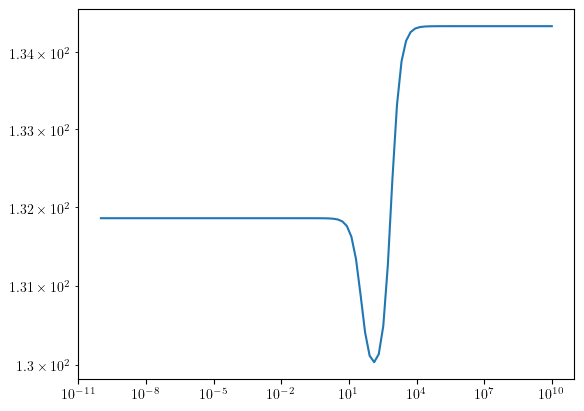

In [30]:
def true_error(L_alpha):
    A = torch.vstack([torch.kron(torch.eye(n_images), masks.T.contiguous()) * (hx * hy)**.5, L_alpha * torch.kron(Tau @ D, torch.eye(n_masks)) / ht**.5])
    alpha_unregistered = torch.linalg.lstsq(A, 
                                            torch.hstack([(d - d[0]).flatten() * (hx * hy)**.5, torch.zeros(D.shape[0]*n_masks)])
                                            )[0].reshape(n_images,n_masks)
    return torch.linalg.norm(alpha_unregistered - alpha_true)

Ls = torch.logspace(-10,10,100)
error = [true_error(L) for L in Ls]

plt.loglog(Ls,error)

In [33]:
L_alpha = Ls[torch.argmin(torch.Tensor(error))]

A = torch.vstack([torch.kron(torch.eye(n_images), masks.T.contiguous()) * (hx * hy)**.5, L_alpha * torch.kron(Tau @ D, torch.eye(n_masks)) / ht**.5])

In [34]:
L_alpha

tensor(132.1941)

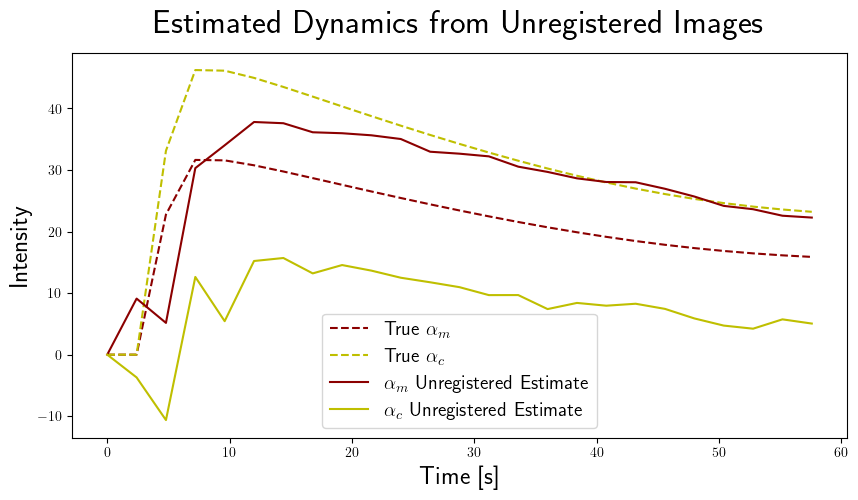

In [35]:
alpha_unregistered = torch.linalg.lstsq(A, 
                                        torch.hstack([(d - d[0]).flatten() * (hx * hy)**.5, torch.zeros(D.shape[0]*n_masks)])
                                        )[0].reshape(n_images,n_masks)

plt.figure(figsize=(10,5))

plt.plot(time, alpha_true[:,0], '--', color='darkred', label=r"True $\alpha_m$")
plt.plot(time, alpha_true[:,1], '--', color='y', label=r"True $\alpha_c$")

plt.plot(time, alpha_unregistered[:,0], color='darkred', label=r"$\alpha_m$ Unregistered Estimate")
plt.plot(time, alpha_unregistered[:,1], color='y', label=r"$\alpha_c$ Unregistered Estimate")

plt.legend(fontsize=14)

plt.xlabel('Time [s]', fontsize=18)
plt.ylabel('Intensity', fontsize=18)

plt.title("Estimated Dynamics from Unregistered Images",fontsize=24, y=1.03)


plt.savefig('results/dynamics/unregistered_alpha.pdf', bbox_inches='tight')

plt.show()

# Solving For Dynamics with Preregistered Images

In [11]:
xc_2d = domain.getCellCenteredGrid()
xc = xc_2d.reshape(mx*my,2).detach()

ys = [Affine2d() for _ in range(n_images-1)]

thetas = torch.logspace(5,-3, 10)

wps = [{k: v.detach() for k, v in y.named_parameters()} for y in ys]
keys_list = [wp.keys() for wp in wps]

flat_params_list, shapes_list, sizes_list = flatten_params_list(wps)
wp_vec = torch.stack(flat_params_list).flatten().unsqueeze(1)

# Start Registration
print(100*'-')
print("Registering Multiple Images :")
print(100*'-')

f_pred = d.clone().detach()

for theta in thetas:
    print("Registering at Scale {} with Gauss Newton".format(theta))

    d_interp = [SplineInter(d[j].reshape(mx,my).clone().detach(), domain, regularizer='moments', theta=theta) for j in range(n_images)]

    d0_stack = torch.vstack([d_interp[0](xc) for _ in range(n_images - 1)]).detach()

    def Forward(wp_vec, xc):
            w_dict = unflatten_params_list(wp_vec.reshape(n_images-1,6), keys_list, shapes_list, sizes_list)
            ycs = [func.functional_call(y, wp, xc) for wp, y in zip(w_dict, ys)]
            f_preds = torch.vstack([d_interp[j+1](ycs[j]) for j in range(n_images - 1)])
            return f_preds, f_preds

    def loss_fn(wp_vec, xc):
        return torch.linalg.norm(Forward(wp_vec, xc)[0] - d0_stack)**2 * torch.prod(domain.h)


    iter = 0

    loss = []
    loss.append(loss_fn(wp_vec, xc))
    gradnorm = []
    gradnorm.append(torch.inf)

    while gradnorm[-1] > 1e-2 and iter < 15:
        print("iter \t {} \t | \t loss \t {} \t | \t gradnorm \t {}".format(iter,loss[-1],gradnorm[-1]))

        Jac, F = func.jacfwd(Forward, has_aux=True)(wp_vec, xc)
        Jac = Jac.squeeze()

        res = F - d0_stack
        gradnorm.append(torch.linalg.norm(Jac.T @ res))
        p = torch.linalg.lstsq(Jac, -res)[0]

        step_size = 1
        for _ in range(10):
            if loss_fn(wp_vec + step_size * p, xc) < loss[iter]:
                wp_vec += step_size * p
                break
            step_size *= .5
        loss.append(loss_fn(wp_vec, xc))

        iter += 1

        f_pred[1:] = F.reshape(n_images - 1, mx*my)

wp_vec_prereg = wp_vec.clone()
f_pred_prereg = f_pred.clone()

----------------------------------------------------------------------------------------------------
Registering Multiple Images :
----------------------------------------------------------------------------------------------------
Registering at Scale 100000.0 with Gauss Newton
iter 	 0 	 | 	 loss 	 51621001.780272014 	 | 	 gradnorm 	 inf
iter 	 1 	 | 	 loss 	 40726855.11583297 	 | 	 gradnorm 	 67209846.79456776
iter 	 2 	 | 	 loss 	 40470694.785011455 	 | 	 gradnorm 	 10425042.830912953
iter 	 3 	 | 	 loss 	 40462580.66870996 	 | 	 gradnorm 	 1981638.4892897448
iter 	 4 	 | 	 loss 	 40462255.80011825 	 | 	 gradnorm 	 428697.84705251624
Registering at Scale 12915.496650148827 with Gauss Newton
iter 	 0 	 | 	 loss 	 106305396.67352104 	 | 	 gradnorm 	 inf
iter 	 1 	 | 	 loss 	 89886818.94104528 	 | 	 gradnorm 	 90109787.02422535
iter 	 2 	 | 	 loss 	 89669701.10222511 	 | 	 gradnorm 	 17769737.058185607
iter 	 3 	 | 	 loss 	 89661342.18513367 	 | 	 gradnorm 	 3948725.7574716327
iter 	 

In [12]:
theta = 0

d_interp = [SplineInter(d[j].reshape(mx,my).detach(), domain, regularizer='moments', theta=0) for j in range(n_images)]

def Forward(wp_vec, xc):
        w_dict = unflatten_params_list(wp_vec.reshape(n_images-1,6), keys_list, shapes_list, sizes_list)
        ycs = [func.functional_call(y, wp, xc) for wp, y in zip(w_dict, ys)]
        f_preds = torch.vstack([d_interp[j+1](ycs[j]) for j in range(n_images - 1)])
        return f_preds, f_preds

f_pred[1:] = Forward(wp_vec, xc)[0].reshape(n_images - 1, mx*my)

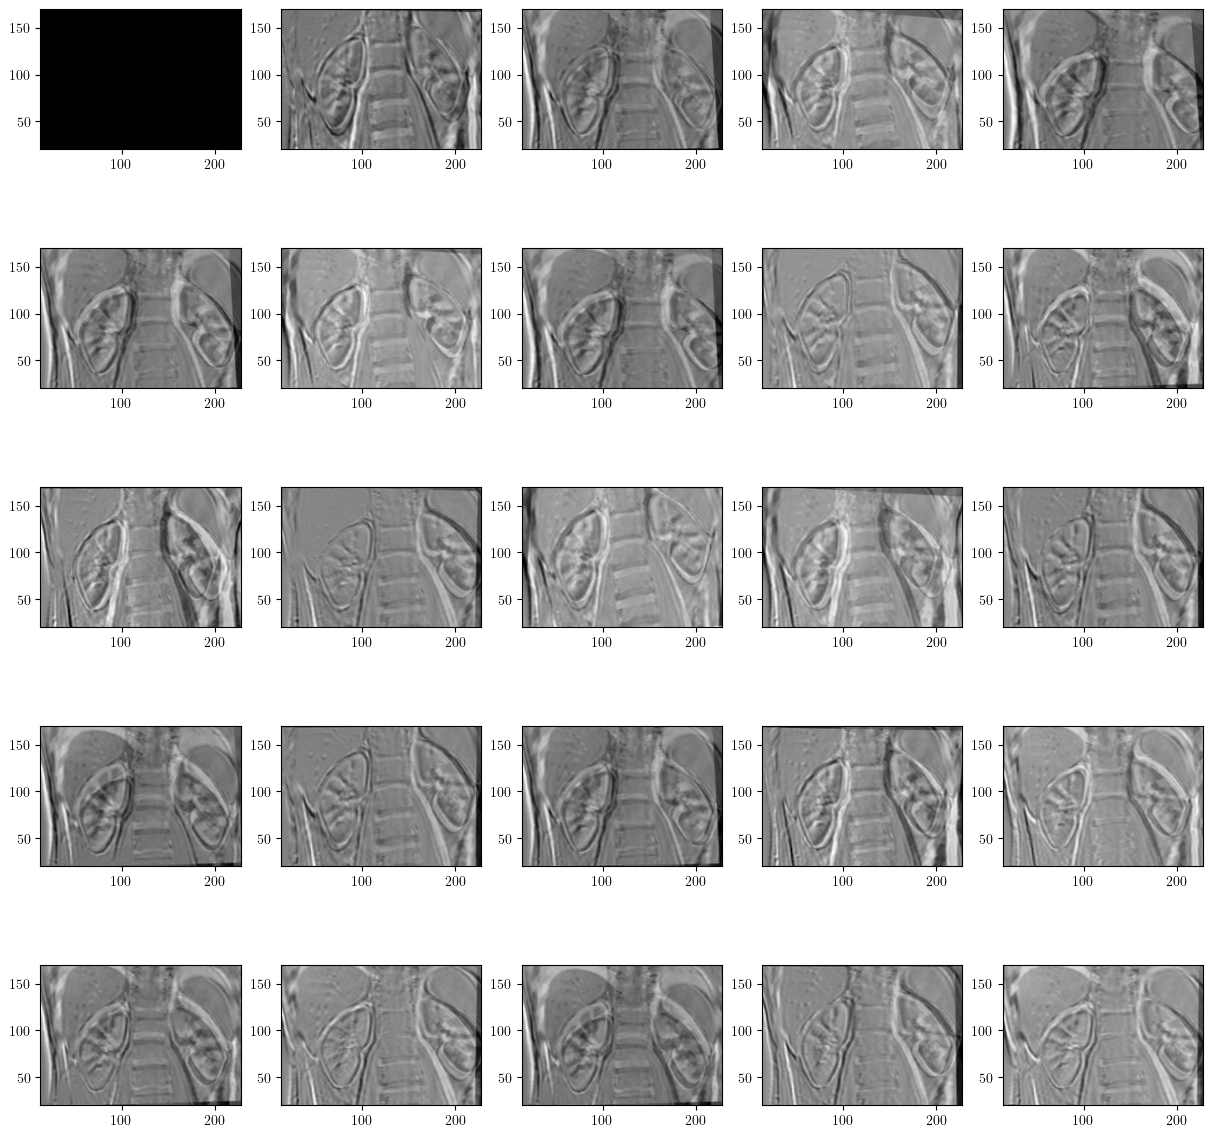

In [13]:
fig, ax = plt.subplots(5,5,figsize=(15,15))

for j in range(0,n_images):
    view_image_2d(f_pred[j].reshape(mx,my).detach() - d_2d[j], domain, ax=ax[j//5,j%5])

In [14]:
alpha_true.shape

torch.Size([25, 2])

In [15]:
torch.diff(torch.eye(n_images-1), dim=0).shape

torch.Size([23, 24])

In [50]:
xc_2d = domain.getCellCenteredGrid()
xc = xc_2d.reshape(mx*my,2).detach()

ys = [Affine2d() for _ in range(n_images-1)]

thetas = torch.logspace(5,-3, 10)

wps = [{k: v.detach() for k, v in y.named_parameters()} for y in ys]
keys_list = [wp.keys() for wp in wps]

flat_params_list, shapes_list, sizes_list = flatten_params_list(wps)
wp_vec = torch.stack(flat_params_list).flatten().unsqueeze(1)

# Start Registration
print(100*'-')
print("Registering Multiple Images :")
print(100*'-')

f_pred = d.clone().detach()

for theta in thetas:
    print("Registering at Scale {} with Gauss Newton".format(theta))
    Mimgs = [
            SplineInter(mask.reshape(mx,my), domain, regularizer='moments', theta=theta) for mask in masks
            ]
    M = (torch.stack([Mimg(xc).detach() for Mimg in Mimgs], dim=-1).squeeze())
    A = torch.vstack([torch.kron(torch.eye(n_images-1), M) * (hx * hy)**.5, L_alpha * torch.kron(torch.diag(1. * (time[:-2] > 10)) @ torch.diff(torch.eye(n_images-1), dim=0), torch.eye(n_masks)) / ht**.5])

    Q,R = torch.linalg.qr(A, mode='reduced')

    def P(image_stack):
        appended_stack = torch.hstack([image_stack.flatten(), torch.zeros((n_images-2)*n_masks)])
        return appended_stack - Q @ (Q.T @ appended_stack)

    d_interp = [SplineInter(d[j].reshape(mx,my).clone().detach(), domain, regularizer='moments', theta=theta) for j in range(n_images)]

    d0_stack = torch.vstack([d_interp[0](xc) for _ in range(n_images - 1)]).detach()

    def Forward(wp_vec, xc):
            w_dict = unflatten_params_list(wp_vec.reshape(n_images-1,6), keys_list, shapes_list, sizes_list)
            ycs = [func.functional_call(y, wp, xc) for wp, y in zip(w_dict, ys)]
            f_preds = torch.vstack([d_interp[j+1](ycs[j]) for j in range(n_images - 1)])
            return f_preds, f_preds

    def loss_fn(wp_vec, xc):
        return torch.linalg.norm(P(Forward(wp_vec, xc)[0] - d0_stack))**2 * torch.prod(domain.h)


    iter = 0

    loss = []
    loss.append(loss_fn(wp_vec, xc))
    gradnorm = []
    gradnorm.append(torch.inf)

    while gradnorm[-1] > 1e-2 and iter < 15:
        print("iter \t {} \t | \t loss \t {} \t | \t gradnorm \t {}".format(iter,loss[-1],gradnorm[-1]))

        Jac, F = func.jacfwd(Forward, has_aux=True)(wp_vec, xc)
        Jac = torch.vmap(P,1,1)(Jac.squeeze())
        res = P(F - d0_stack)


        gradnorm.append(torch.linalg.norm(Jac.T @ res))
        p = torch.linalg.lstsq(Jac, -res)[0].unsqueeze(1)

        step_size = 1
        for _ in range(10):
            if loss_fn(wp_vec + step_size * p, xc) < loss[iter]:
                wp_vec += step_size * p
                break
            step_size *= .5
        loss.append(loss_fn(wp_vec, xc))

        iter += 1

        f_pred[1:] = F.reshape(n_images - 1, mx*my)

wp_vec_coupled = wp_vec.clone()
f_pred_coupled = f_pred.clone()

----------------------------------------------------------------------------------------------------
Registering Multiple Images :
----------------------------------------------------------------------------------------------------
Registering at Scale 100000.0 with Gauss Newton
iter 	 0 	 | 	 loss 	 15360091.917793272 	 | 	 gradnorm 	 inf
iter 	 1 	 | 	 loss 	 11466128.416095745 	 | 	 gradnorm 	 47737004.56465928
iter 	 2 	 | 	 loss 	 11453186.315819135 	 | 	 gradnorm 	 2094428.2981911341
iter 	 3 	 | 	 loss 	 11453084.039399732 	 | 	 gradnorm 	 204219.17178993335
iter 	 4 	 | 	 loss 	 11453082.686584583 	 | 	 gradnorm 	 19645.583658846015
Registering at Scale 12915.496650148827 with Gauss Newton
iter 	 0 	 | 	 loss 	 35144564.10318923 	 | 	 gradnorm 	 inf
iter 	 1 	 | 	 loss 	 30677987.00831942 	 | 	 gradnorm 	 86491594.22859837
iter 	 2 	 | 	 loss 	 30668583.448692765 	 | 	 gradnorm 	 3773663.2868833984
iter 	 3 	 | 	 loss 	 30668532.00922581 	 | 	 gradnorm 	 336940.6423815909
iter 

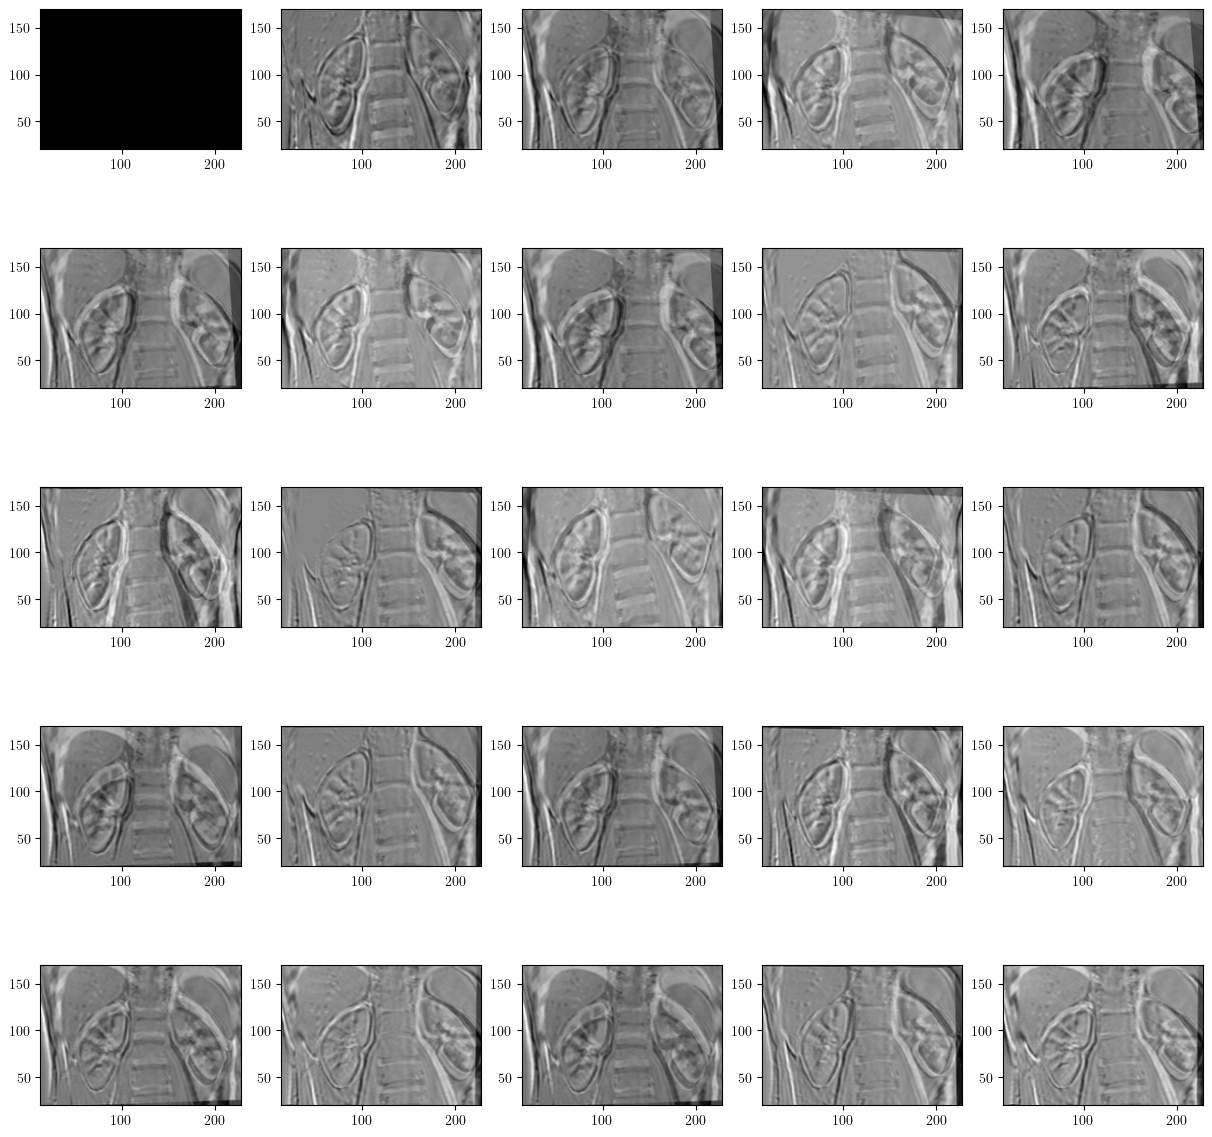

In [51]:
fig, ax = plt.subplots(5,5,figsize=(15,15))

for j in range(0,n_images):
    view_image_2d(f_pred[j].reshape(mx,my).detach() - d_2d[j], domain, ax=ax[j//5,j%5])

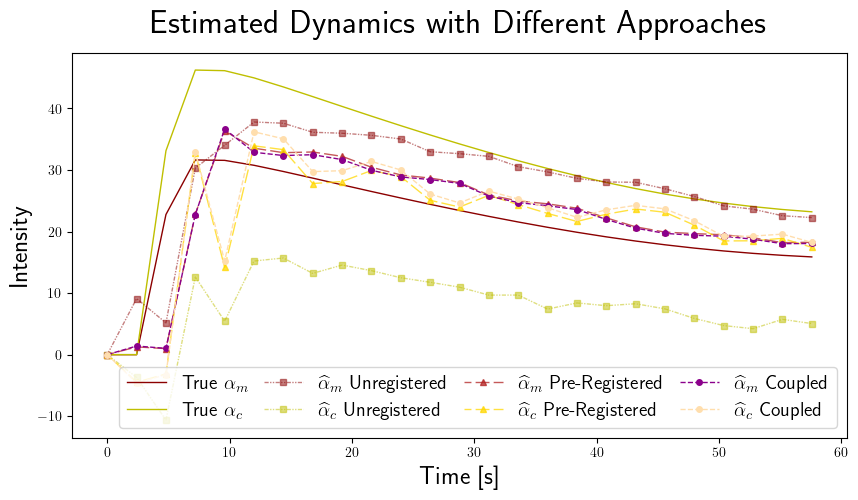

In [57]:
A = torch.vstack([torch.kron(torch.eye(n_images), M) * (hx * hy)**.5, L_alpha * torch.kron(Tau @ D, torch.eye(n_masks)) / ht**.5])

alpha_preregistered = torch.linalg.lstsq(A, 
                   torch.hstack([(f_pred_prereg - d[0]).flatten() * (hx * hy)**.5, torch.zeros(D.shape[0]*n_masks)])
                   )[0].reshape(n_images,n_masks)

alpha_coupled = torch.linalg.lstsq(A, 
                   torch.hstack([(f_pred_coupled - d[0]).flatten() * (hx * hy)**.5, torch.zeros(D.shape[0]*n_masks)])
                   )[0].reshape(n_images,n_masks)


plt.figure(figsize=(10,5))

plt.plot(time, alpha_true[:,0], linewidth=1, color='darkred', label=r"True $\alpha_m$", alpha=1)
plt.plot(time, alpha_true[:,1], linewidth=1, color='y', label=r"True $\alpha_c$", alpha=1)

plt.plot(time, alpha_unregistered[:,0], 's', markersize=4, linewidth=1, linestyle=(0, (3, 1, 1, 1, 1, 1)), color='darkred', label=r"$\widehat{\alpha}_m$ Unregistered", alpha=.5)
plt.plot(time, alpha_unregistered[:,1], 's', markersize=4, linewidth=1, linestyle=(0, (3, 1, 1, 1, 1, 1)), color='y', label=r"$\widehat{\alpha}_c$ Unregistered", alpha=.5)

plt.plot(time, alpha_preregistered[:,0], '^', markersize=4, linewidth=1, linestyle=(5,(10,3)), color='firebrick', label=r"$\widehat{\alpha}_m$ Pre-Registered", alpha=.75)
plt.plot(time, alpha_preregistered[:,1], '^', markersize=4, linewidth=1, linestyle=(5,(10,3)), color='gold', label=r"$\widehat{\alpha}_c$ Pre-Registered", alpha=.75)

plt.plot(time, alpha_coupled[:,0], 'o', markersize=4, linewidth=1, linestyle='dashed', color='darkmagenta', label=r"$\widehat{\alpha}_m$ Coupled")
plt.plot(time, alpha_coupled[:,1], 'o', markersize=4, linewidth=1, linestyle='dashed', color='navajowhite', label=r"$\widehat{\alpha}_c$ Coupled")


plt.legend(fontsize=14, loc = 'lower right', ncol=4, columnspacing=0.8)

plt.xlabel('Time [s]', fontsize=18)
plt.ylabel('Intensity', fontsize=18)

plt.title("Estimated Dynamics with Different Approaches",fontsize=24, y=1.03)

plt.savefig('results/dynamics/alpha_estimation.pdf', bbox_inches='tight')

plt.show()